# Prédiction de la note des vins

Le notebook compare plusieurs de modèles de régression.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = yn = df['quality']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données.

In [4]:
from sklearn.preprocessing import normalize
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)
X_norm = normalize(X)

Cette façon de faire est complètement erronnée car il est peu probable que la même normalisation soit apppliquée sur les trois bases. La normalisation doit être estimée sur la base d'apprentissage et appliquée sur la base de test. Reprenons.

In [5]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)
X_norm = norm.transform(X)

On récupère beaucoup de modèles implémentés dans *scikit-learn* pour la régression.

In [6]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.neural_network import *

models = [model for name, model in globals().items() if hasattr(model, 'fit') and \
                                                not hasattr(model, 'predict_proba') and \
                                                hasattr(model, '__name__') and \
                                                not model.__name__.endswith('CV') and \
                                                'Logistic' not in model.__name__ and \
                                                'Regr' in model.__name__]

import pprint
pprint.pprint(models)

[<class 'sklearn.linear_model.bayes.ARDRegression'>,
 <class 'sklearn.linear_model.huber.HuberRegressor'>,
 <class 'sklearn.linear_model.base.LinearRegression'>,
 <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'>,
 <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'>,
 <class 'sklearn.linear_model.theil_sen.TheilSenRegressor'>,
 <class 'sklearn.linear_model.ransac.RANSACRegressor'>,
 <class 'sklearn.ensemble.forest.RandomForestRegressor'>,
 <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>,
 <class 'sklearn.ensemble.bagging.BaggingRegressor'>,
 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>,
 <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>,
 <class 'sklearn.ensemble.voting.VotingRegressor'>,
 <class 'sklearn.neighbors.regression.KNeighborsRegressor'>,
 <class 'sklearn.neighbors.regression.RadiusNeighborsRegressor'>,
 <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>]


In [7]:
from sklearn.metrics import r2_score

def score_model(xtr, xte, ytr, yte, model):
    try:
        model.fit(xtr, ytr)
    except Exception as e:
        raise Exception("Issue with model '{0}'".format(model.__name__)) from e
    return r2_score(yte, model.predict(xte))

In [8]:
from time import perf_counter 
r2s = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression', 'VotingRegressor'}:
        continue
    begin = perf_counter()
    reg = model()
    r2 = score_model(X_train_norm, X_test_norm, y_train, y_test, reg)
    duree = perf_counter () - begin
    r2s.append(r2)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, duree)

1 HuberRegressor 0.167908928783702 0.1319578850000056
2 LinearRegression 0.18128907129349636 0.002410670000003279
3 PassiveAggressiveRegressor -0.40746132845763605 0.011577298000005953
4 SGDRegressor 0.018605206212356173 0.007524355000001037
5 TheilSenRegressor -0.34170146474357943 2.90146082199999
6 RANSACRegressor -1.7547923772659266 0.09221620800001062
7 RandomForestRegressor 0.4855517662710309 3.960289137999993
8 ExtraTreesRegressor 0.5137256975205859 1.3310194539999998
9 BaggingRegressor 0.4296252699314196 0.39791178000000116
10 GradientBoostingRegressor 0.3383864181478641 0.49762508399999206
11 AdaBoostRegressor 0.20419077584033374 0.34612347200000215
13 KNeighborsRegressor 0.17825163540867428 0.027565069999994307
14 RadiusNeighborsRegressor -0.0012266149264537063 0.4551993540000012
15 MLPRegressor 0.18477447383824053 2.9864367250000043


C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [9]:
import pandas
df = pandas.DataFrame(dict(model=names, r2=r2s, duree=durations))
df = df[['model', 'r2', 'duree']]
df.sort_values('r2')

,model,r2,duree
5,RANSACRegressor,-1.754792,0.092216
2,PassiveAggressiveRegressor,-0.407461,0.011577
4,TheilSenRegressor,-0.341701,2.901461
12,RadiusNeighborsRegressor,-0.001227,0.455199
3,SGDRegressor,0.018605,0.007524
0,HuberRegressor,0.167909,0.131958
11,KNeighborsRegressor,0.178252,0.027565
1,LinearRegression,0.181289,0.002411
13,MLPRegressor,0.184774,2.986437
10,AdaBoostRegressor,0.204191,0.346123


On filtre les valeurs inférieures à -1.

In [10]:
df = df[df.r2 >= -1]

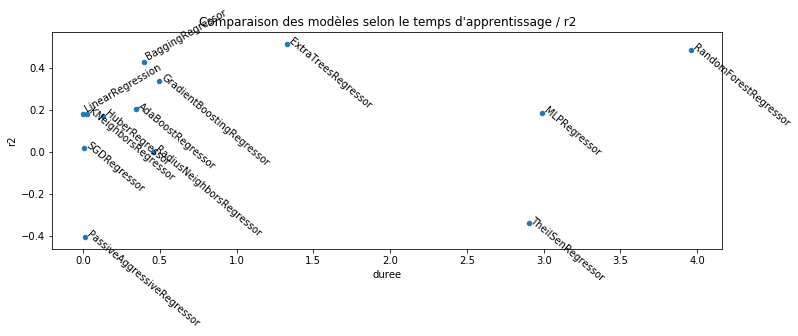

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df.plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, x = row[1:4]
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2");

L'estimateur [RANSACRegressor](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py) produit un $R^2$ très négatif. Regardons plus en détail.

In [12]:
pred = regressors['RANSACRegressor'].predict(X_test_norm)

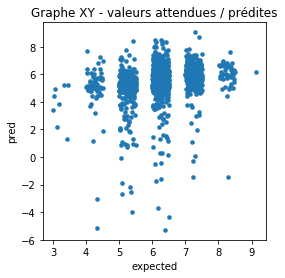

In [13]:
import numpy.random
df = pandas.DataFrame(dict(pred=pred, expected=y_test))
df['expected'] += numpy.random.random(df.shape[0]) * 0.5
ax = df.plot(x="expected", y="pred", kind='scatter', figsize=(4, 4), linewidths=0.1)
ax.set_title('Graphe XY - valeurs attendues / prédites');

Essayons de voir avec la densité.

c:\Python372_x64\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


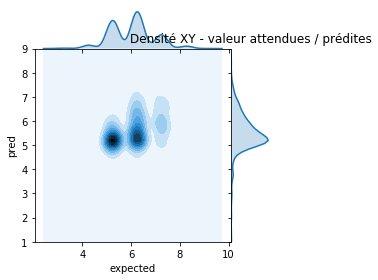

In [14]:
import seaborn
ax = seaborn.jointplot(df["expected"], df["pred"], kind="kde", size=4, space=0, ylim=(1, 9))
ax.ax_marg_y.set_title('Densité XY - valeur attendues / prédites');

Pas facile à voir. Essayons de voir autrement en triant les prédictions et les valeurs attendues par ordre.

In [15]:
sv = df.sort_values(['expected', 'pred']).reset_index(drop=True)

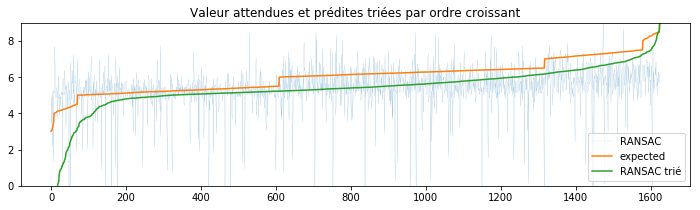

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(sv["pred"], label="RANSAC", lw=0.1)
ax.plot(list(sorted(df["expected"])), label="expected")
ax.plot(list(sorted(df["pred"])), label="RANSAC trié")
ax.set_ylim([0, 9])
ax.set_title('Valeur attendues et prédites triées par ordre croissant')
ax.legend();

Le modèle est plutôt agité.

In [17]:
regressors['RANSACRegressor'].estimator_.intercept_

-32.02748946906758

Pour s'assurer que les résultats sont fiables, il faut recommencer avec une validation croisée.

In [18]:
import numpy.random
rnd = numpy.random.permutation(range(X_norm.shape[0]))
xns = X_norm[rnd, :]
yns = yn[rnd]
xns.shape, yns.shape

((6497, 11), (6497,))

In [19]:
from sklearn.model_selection import cross_val_score

def score_model_cross(xn, yn, model):
    res = cross_val_score(model, xn, yn, cv=5)
    return res.mean(), min(res), max(res)

score_model_cross(xns, yns, LinearRegression())

(0.1773492127294107, 0.13977044635378144, 0.19448650958931857)

In [20]:
r2s = []
mis = []
mas = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression', 'VotingRegressor'}:
        continue
    begin = perf_counter()
    reg = model()
    r2, mi, ma = score_model_cross(xns, yns, reg)
    duree = perf_counter() - begin
    r2s.append(r2)
    mis.append(mi)
    mas.append(ma)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, mi, ma, duree)

1 HuberRegressor 0.15781268354344816 0.13420044243451645 0.17488141786505762 0.5031535840000174
2 LinearRegression 0.1773492127294107 0.13977044635378144 0.19448650958931857 0.015249006000004783
3 PassiveAggressiveRegressor 0.0025130716980821255 -0.14081120653830048 0.13116198159577008 0.056741203000001406
4 SGDRegressor 0.007076310690353349 -0.013131315988931691 0.01605717725179079 0.05062524600000984
5 TheilSenRegressor -0.33887595075092836 -0.5262092430313627 -0.16165087842742043 13.637747719000004
6 RANSACRegressor -5.358203353528837 -18.63599503355946 -0.6420111970244675 0.4042608249999944
7 RandomForestRegressor 0.4879609486516407 0.46293415845271124 0.5195583516179589 22.724700118000015
8 ExtraTreesRegressor 0.5204788021263941 0.496558894630847 0.5543390504286901 8.475466440000048
9 BaggingRegressor 0.4453742051351005 0.41616950757575766 0.49003853600073777 2.417469335000021
10 GradientBoostingRegressor 0.330763396708637 0.3082984891394036 0.34399142811014616 2.727394836999963
1

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % sel

15 MLPRegressor 0.1796604158796548 0.17404407470132088 0.1938257148694147 21.408994065


C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
df = pandas.DataFrame(dict(model=names, r2=r2s, min=mis, max=mas, duree=durations))
df = df[['model', 'r2', 'min', 'max', 'duree']]
df.sort_values('r2')

,model,r2,min,max,duree
5,RANSACRegressor,-5.358203,-18.635995,-0.642011,0.404261
4,TheilSenRegressor,-0.338876,-0.526209,-0.161651,13.637748
12,RadiusNeighborsRegressor,-0.004268,-0.011699,0.000120,2.630350
2,PassiveAggressiveRegressor,0.002513,-0.140811,0.131162,0.056741
3,SGDRegressor,0.007076,-0.013131,0.016057,0.050625
0,HuberRegressor,0.157813,0.134200,0.174881,0.503154
11,KNeighborsRegressor,0.159468,0.109165,0.189285,0.155197
1,LinearRegression,0.177349,0.139770,0.194487,0.015249
13,MLPRegressor,0.179660,0.174044,0.193826,21.408994
10,AdaBoostRegressor,0.191600,0.185973,0.202281,2.887246


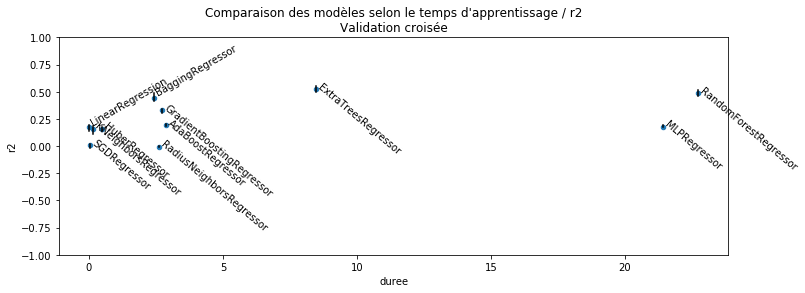

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df[df['min'] > -0.1].plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, mi, ma, x = row[1:6]
    if mi < -0.1:
        continue
    ax.plot([x, x], [mi, ma], color="black")
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_ylim([-1, 1])
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2\nValidation croisée");

Le modèle [RANSAC](http://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus) est conçu pour apprendre un modèle linéaire et réduire l'ensemble d'apprentissage aux points non aberrants. Dans notre cas, vu le peu d'exemples pour les notes élevées, il est très probable que celles-ci disparaissent des observations choisies pour estimer le modèle : le modèle choisit d'évincer les exemples pour lesquels l'erreur est la plus grande en considérant que cela est une indication du fait qu'ils sont aberrants. Malgré cela, sa faible capacité à prévoir vient du fait que la majorité des vins ont une note entre 4 et 6 et que finalement, il y a peu de différences : ils sont tous moyens et la différence s'explique par d'autres facteurs comme le juge ayant donné la note.